In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

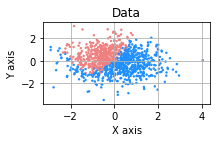

In [2]:
import matplotlib

colors = ['lightcoral', 'dodgerblue']


fileName = 'datosT1P3.txt'
data = np.genfromtxt(fileName, delimiter=',')


fig = plt.figure(0,(3,1.5))
plt.scatter(data[0,:],data[1,:], c=data[2,:], cmap = mcolors.ListedColormap(colors), s = 2)
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.grid()

plt.show(fig)

In [3]:
import theano.tensor as tt

def sigmoid2D(x1,x2, beta0, beta1, beta2):
    return 1.0/(1+tt.exp(-beta0 - beta1*x1-beta2*x2))

In [4]:
import mle
import theano.tensor as tt
import theano


def alltrue(conditionals):
    ret = 1
    for condition in conditionals:
        ret *= condition
    return ret

def bound(logp, *conditionals):
    return tt.switch(alltrue(conditionals), logp, -np.inf)

class Bernoulli(mle.Model):
    def __init__(self, x,p, *args, **kwargs):
        super(Bernoulli, self).__init__(*args, **kwargs)
        self._logp = bound(
            y*tt.log(p)+(1-y)*tt.log(1-p), p >= 0, p <= 1
        )
        self._add_expr('p', p)
        
# for ommit AttributeError: x has no test value
theano.config.compute_test_value = 'ignore'

X1 = data[0,:]
X2 = data[1,:]

# print('X shape: %s' % X.shape)

Y = data[2,:]
print('Y shape: %s' % Y.shape)

# Define model
x = mle.var('x', observed=True, vector=True)
y = mle.var('y', observed=True, vector=True)

beta0 = mle.var('beta0')
beta1 = mle.var('beta1')
beta2 = mle.var('beta2')


model = Bernoulli(y, sigmoid2D(X1,X2,beta0,beta1,beta2))


# Fit model to data
result = model.fit({'x': data[0:2,:], 'y': Y}, {'beta0': 1, 'beta1': 1, 'beta2': 1})
print(result)
beta = result.x

Y shape: 1000
Optimization terminated successfully.
         Current function value: 346.925959
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22
 fit_time: 0.010460999999999387
      fun: 346.92595872829236
 hess_inv: array([[ 0.00999769,  0.00515836, -0.00479152],
       [ 0.00515836,  0.02321898, -0.01451781],
       [-0.00479152, -0.01451781,  0.02499734]])
      jac: array([ -8.10746859e-10,  -5.99249945e-07,  -8.23895436e-08])
  message: 'Optimization terminated successfully.'
     nfev: 22
      nit: 17
     njev: 22
   status: 0
  success: True
        x: {'beta0': 0.71665062696408344, 'beta1': 2.231767326377605, 'beta2': -2.1964847478348686}


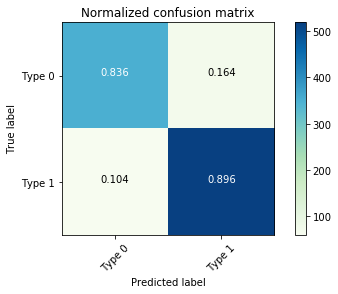

In [6]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],3)
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


confMatrix = confusion_matrix(data[2,:], predicted)
class_names = ['Type 0', 'Type 1']
plot_confusion_matrix(confMatrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix', cmap=plt.cm.GnBu)
plt.savefig('confMatrix.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

# Maximum A Posteriori Model

Sigmoid Model is given by:

$$
\text{sigmoid2D}(x_1,x_2) = \frac{1}{1+e^{-\beta_0 - \beta_1x_1 - \beta_2x_2}}
$$

In this case our prior over parameters are:

$$
\beta_0 \sim N(\beta^{init}_0, \sigma_0^2)\\
\beta_1 \sim N(\beta^{init}_1, \sigma_1^2)\\
\beta_2 \sim N(\beta^{init}_2, \sigma_2^2)
$$

Where $\beta_i^0$  $\forall i = 0, 1, 2$ are the values found in the past section.

Finally, we assume that each class distibutes as Bernoulli. That is mean:

$$
Y_{obs}(x^i) \sim Ber(p(x^i))\\
p(x^i) = \frac{1}{1+e^{-\beta_0 - \beta_1x_1^i-\beta_2x_2^i}}
$$

In [13]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    beta0 = pm.Normal('beta0', mu=beta['beta0'], sd=100)
    beta1 = pm.Normal('beta1', mu=beta['beta1'], sd=100)
    beta2 = pm.Normal('beta2', mu=beta['beta2'], sd=100)

    # Expected value of outcome
    p_sigmoid = sigmoid2D(data[0,:],data[1,:],beta0,beta1,beta2)
    # mu_obs = np.sum(np.dot(theta,X_aux),axis = 1)
    # print('mu_obs shape: %s'% mu_obs.shape)
        
    # Model
    Y_obs = pm.Bernoulli('Y_obs', p=p_sigmoid, observed=data[2,:])
    
    # sample using Metropolis
    step = pm.Metropolis()
    trace = pm.sample(10000, step)

/home/lerko/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
100%|██████████| 10000/10000 [00:11<00:00, 857.87it/s]


beta_0: 0.716650626964
beta_1: 2.23176732638
beta_2: -2.19648474783
{'beta0': 0.71665062696408344, 'beta1': 2.231767326377605, 'beta2': -2.1964847478348686}


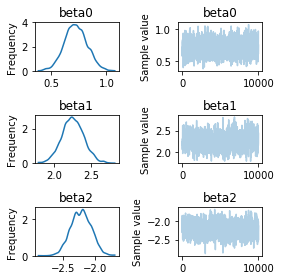

In [16]:
print('beta_0: %s\nbeta_1: %s\nbeta_2: %s' % (beta['beta0'], beta['beta1'], beta['beta2']))
print(trace)
pm.traceplot(trace, figsize = (4,4));
plt.savefig('Metropolis2.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

Classification rate: 0.871


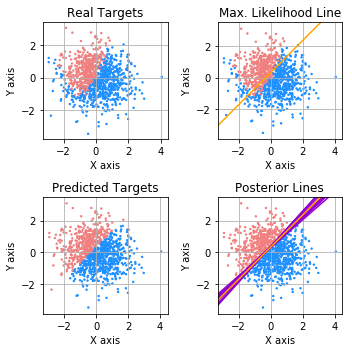

In [42]:
from sklearn.metrics import confusion_matrix

def predict(data, beta):
    return 1.0/(1+np.exp(-beta['beta0'] - beta['beta1']*data[0,:]-beta['beta2']*data[1,:]))

predicted = predict(data,beta) > 0.5

classRate = np.sum(data[2,:] == predicted) / predicted.shape[0]
print('Classification rate: %s' % classRate)

m = -beta['beta1']/beta['beta2']
n = -beta['beta0']/beta['beta2']

x1_aux = np.array([np.min(data[0,:])-1, np.max(data[0,:])+1])
rect = m*x1_aux+n

fig, ax = plt.subplots(2,2)
fig.set_figheight(5)
fig.set_figwidth(5)


ax[0,0].scatter(data[0,:],data[1,:], c=data[2,:], cmap = mcolors.ListedColormap(colors), s = 2)
ax[0,0].set_title('Real Targets')
ax[0,0].set_xlabel('X axis')
ax[0,0].set_ylabel('Y axis')
ax[0,0].grid()


ax[0,1].scatter(data[0,:],data[1,:], c=data[2,:], cmap = mcolors.ListedColormap(colors), s = 2)
ax[0,1].plot(x1_aux, rect, color = 'orange')
ax[0,1].set_xlim(np.array([np.min(data[0,:])-0.4, np.max(data[0,:])+0.4]))
ax[0,1].set_ylim(np.array([np.min(data[1,:])-0.4, np.max(data[1,:])+0.4]))
ax[0,1].set_title('Max. Likelihood Line')
ax[0,1].set_xlabel('X axis')
ax[0,1].set_ylabel('Y axis')
ax[0,1].grid()


ax[1,1].scatter(data[0,:],data[1,:], c=predicted, cmap = mcolors.ListedColormap(colors), s = 2)
ax[1,1].set_title('Posterior Lines')
ax[1,1].set_xlabel('X axis')
ax[1,1].set_ylabel('Y axis')
ax[1,1].grid()


numberOfLines = 20
for i in range(numberOfLines):
    beta_aux = trace[i]
    
    m = -beta_aux['beta1']/beta_aux['beta2']
    n = -beta_aux['beta0']/beta_aux['beta2']
    
    rect_aux = m*x1_aux+n
    
    ax[1,1].plot(x1_aux, rect_aux, color = 'darkviolet')
ax[1,1].plot(x1_aux, rect, color = 'orange')
ax[1,1].set_xlim(np.array([np.min(data[0,:])-0.4, np.max(data[0,:])+0.4]))
ax[1,1].set_ylim(np.array([np.min(data[1,:])-0.4, np.max(data[1,:])+0.4]))

ax[1,0].scatter(data[0,:],data[1,:], c=predicted, cmap = mcolors.ListedColormap(colors), s = 2)
ax[1,0].set_title('Predicted Targets')
ax[1,0].set_xlabel('X axis')
ax[1,0].set_ylabel('Y axis')
ax[1,0].grid()
ax[1,0].set_xlim(np.array([np.min(data[0,:])-0.4, np.max(data[0,:])+0.4]))
ax[1,0].set_ylim(np.array([np.min(data[1,:])-0.4, np.max(data[1,:])+0.4]))
    

plt.tight_layout()
plt.savefig('classes.eps', format = 'eps', bbox_inches = 'tight')

plt.show(fig)